In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.4.0


In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
!unzip /content/gdrive/MyDrive/GAN_datasets/photo2cartoon.zip -d /

Archive:  /content/gdrive/MyDrive/GAN_datasets/photo2cartoon.zip
  inflating: /testB/194.png          
  inflating: /testB/195.png          
  inflating: /testB/196.png          
  inflating: /testB/197.png          
  inflating: /testB/198.png          
  inflating: /testB/199.png          
  inflating: /testB/200.png          
  inflating: /testB/201.png          
  inflating: /testB/202.png          
  inflating: /testB/203.png          
  inflating: /trainB/000.png         
  inflating: /trainB/001.png         
  inflating: /trainB/002.png         
  inflating: /trainB/003.png         
  inflating: /trainB/004.png         
  inflating: /trainB/005.png         
  inflating: /trainB/006.png         
  inflating: /trainB/007.png         
  inflating: /trainB/008.png         
  inflating: /trainB/009.png         
  inflating: /trainB/010.png         
  inflating: /trainB/011.png         
  inflating: /trainB/012.png         
  inflating: /trainB/013.png         
  inflating: /trainB/01

In [6]:
!ls /

bin	 dev   lib32  opt   sbin   tensorflow-1.15.2  tools   var
boot	 etc   lib64  proc  srv    testA	      trainA
content  home  media  root  swift  testB	      trainB
datalab  lib   mnt    run   sys    tmp		      usr


In [10]:
import glob
faces = glob.glob('/trainA/*.jpg')
cartoons = glob.glob("/trainB/*.png")
faces_test = glob.glob('/testA/*.jpg')
cartoons_test = glob.glob('/testB/*.png')

In [14]:
import glob
path = "/Users/k15/Downloads/facescrub/"
faces = glob.glob(path + '/*/*/*.jpeg')[:35000]
bitmojis = glob.glob(path + "../BitmojiDataset/*/*.jpg")
faces_test = glob.glob(path + '/*/*/*.jpeg')[35000:]

In [15]:
len(faces), len(bitmojis), len(faces_test)

(35000, 4084, 7196)

In [17]:
import cv2
for file in bitmojis[:10]:
    img = cv2.imread(file)
    print (img.shape)

(384, 384, 3)
(384, 384, 3)
(384, 384, 3)
(384, 384, 3)
(384, 384, 3)
(384, 384, 3)
(384, 384, 3)
(384, 384, 3)
(384, 384, 3)
(384, 384, 3)


Human Faces


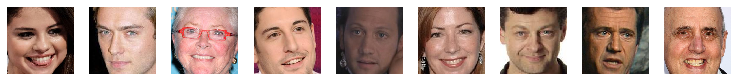

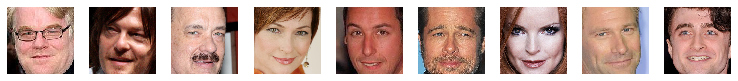

--------------------------------------------------------------------------------
Bitmojis


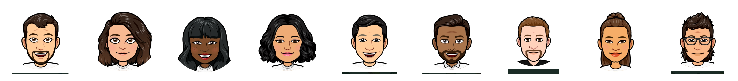

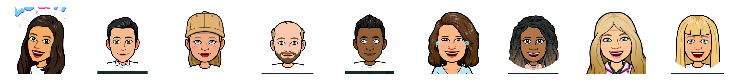

In [18]:
print ("Human Faces")
for k in range(2):
    plt.figure(figsize=(13, 13))
    for j in range(9):
        file = np.random.choice(faces)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(990 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

print ("-"*80)
print ("Bitmojis")
for k in range(2):
    plt.figure(figsize=(13, 13))
    for j in range(9):
        file = np.random.choice(bitmojis)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(990 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Generator Model (U-Net Like)

In [19]:
import tensorflow_addons as tfa

In [20]:
def encoder_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        #x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
        x = tfa.layers.InstanceNormalization()(x)
    return x

def decoder_layer(input_layer, skip_input, filters):
    #x = tensorflow.keras.layers.UpSampling2D(size=2)(input_layer)
    x = tensorflow.keras.layers.Conv2DTranspose(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.Activation('relu')(x)
    #x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = tensorflow.keras.layers.Concatenate()([x, skip_input])
    return x

In [21]:
def make_generator():
    source_image = tensorflow.keras.layers.Input(shape=(128, 128, 3))

    e1 = encoder_layer(source_image, 64, bn=False)
    e2 = encoder_layer(e1, 128)
    e3 = encoder_layer(e2, 256)
    # e4 = encoder_layer(e3, 256)
    e5 = encoder_layer(e3, 512)
    e6 = encoder_layer(e5, 512)
    e7 = encoder_layer(e6, 512)

    bottle_neck = tensorflow.keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same')(e7)
    b = tensorflow.keras.layers.Activation('relu')(bottle_neck)

    d1 = decoder_layer(b, e7, 512)
    d2 = decoder_layer(d1, e6, 512)
    d3 = decoder_layer(d2, e5, 512)
    # d4 = decoder_layer(d3, e4, 256)
    d5 = decoder_layer(d3, e3, 256)
    d6 = decoder_layer(d5, e2, 128)
    d7 = decoder_layer(d6, e1, 64)

    decoded = tensorflow.keras.layers.Conv2DTranspose(3, kernel_size=(4,4), strides=(2,2), padding='same')(d7)
    translated_image = tensorflow.keras.layers.Activation('tanh')(decoded)
    return source_image, translated_image

source_image, translated_image = make_generator()
generator_network = tensorflow.keras.models.Model(inputs=source_image, outputs=translated_image)
print (generator_network.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   3136        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 128)  131200      leaky_re_lu[0][0]                
______________________________________________________________________________________________

# Discriminator Network

In [22]:
def my_conv_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        #x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
        x = tfa.layers.InstanceNormalization()(x)
    return x

In [23]:
 def make_discriminator():
    target_image_input = tensorflow.keras.layers.Input(shape=(128, 128, 3))

    x = my_conv_layer(target_image_input, 64, bn=False)
    x = my_conv_layer(x, 128)
    x = my_conv_layer(x, 256)
    # x = my_conv_layer(x, 512)
    x = my_conv_layer(x, 512)

    patch_features = tensorflow.keras.layers.Conv2D(1, kernel_size=(4,4), strides=(1,1), padding='same')(x)
    return target_image_input, patch_features


target_image_input, patch_features = make_discriminator()
discriminator_network = tensorflow.keras.models.Model(inputs=target_image_input, outputs=patch_features)

print (discriminator_network.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        3136      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 128)       131200    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
instance_normalization_11 (I (None, 32, 32, 128)       256       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 256)       5245

In [24]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_network.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])

# Custom-CARTOON-GAN

In [25]:
source_image = tensorflow.keras.layers.Input(shape=(128, 128, 3))

# Domain Transfer
fake_cartoon = generator_network(source_image)
  
discriminator_network.trainable=False

# Tell Real vs Fake
real_vs_fake = discriminator_network(fake_cartoon)

cartoon_gan = tensorflow.keras.models.Model(inputs = source_image, outputs = [real_vs_fake, fake_cartoon])
cartoon_gan.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
model (Functional)           (None, 128, 128, 3)       41833475  
_________________________________________________________________
model_1 (Functional)         (None, 8, 8, 1)           2766529   
Total params: 44,600,004
Trainable params: 41,833,475
Non-trainable params: 2,766,529
_________________________________________________________________


# VGG features

In [26]:
image_input = tensorflow.keras.layers.Input(shape=(128, 128, 3))

pre_trained_vgg = tensorflow.keras.applications.vgg19.VGG19(weights='imagenet', input_shape=(128, 128, 3), include_top=False)
pre_trained_vgg_model = tensorflow.keras.models.Model(inputs=pre_trained_vgg.input, outputs=pre_trained_vgg.get_layer('block4_conv4').output)

pre_trained_image_feautures = pre_trained_vgg_model(image_input)

custom_vgg = tensorflow.keras.models.Model(inputs=image_input, outputs=pre_trained_image_feautures)
print (custom_vgg.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
model_3 (Functional)         (None, 16, 16, 512)       10585152  
Total params: 10,585,152
Trainable params: 10,585,152
Non-trainable params: 0
_________________________________________________________________
None


# Custom GAN Loss (vgg content Loss)

In [27]:
def custom_gan_loss(y_true, y_pred):
    custom_vgg.trainable=False
    y_true_features = custom_vgg(y_true)
    y_pred_features = custom_vgg(y_pred)
    content_loss = tensorflow.compat.v1.losses.absolute_difference(y_true_features, y_pred_features)
    return content_loss

# Compiling Models

In [28]:
cartoon_gan.compile(loss=['mse', custom_gan_loss], optimizer=adam_optimizer, loss_weights=[1, 10])

# Define Data Generators

In [32]:
def faces_to_cartoons(faces, generator_network):
    generated_samples = generator_network.predict_on_batch(faces)
    return generated_samples

def do_smoothing(img):
    # taken from https://github.com/penny4860/Keras-CartoonGan/blob/master/cartoon/utils.py
    kernel_size = 5
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    gauss = cv2.getGaussianKernel(kernel_size, 0)
    gauss = gauss * gauss.transpose(1, 0)

    rgb_img = img
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    pad_img = np.pad(rgb_img, ((2,2), (2,2), (0,0)), mode='reflect')
    edges = cv2.Canny(gray_img, 100, 200)
    dilation = cv2.dilate(edges, kernel)

    gauss_img = np.copy(rgb_img)
    idx = np.where(dilation != 0)
    for i in range(np.sum(dilation != 0)):
        gauss_img[idx[0][i], idx[1][i], 0] = np.sum(np.multiply(pad_img[idx[0][i]:idx[0][i] + kernel_size, idx[1][i]:idx[1][i] + kernel_size, 0], gauss))
        gauss_img[idx[0][i], idx[1][i], 1] = np.sum(np.multiply(pad_img[idx[0][i]:idx[0][i] + kernel_size, idx[1][i]:idx[1][i] + kernel_size, 1], gauss))
        gauss_img[idx[0][i], idx[1][i], 2] = np.sum(np.multiply(pad_img[idx[0][i]:idx[0][i] + kernel_size, idx[1][i]:idx[1][i] + kernel_size, 2], gauss))

    return gauss_img

def get_training_samples(batch_size):
    random_files = np.random.choice(faces, size=batch_size)
    images = []
    for file in random_files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        images.append((img-127.5)/127.5)
    face_images = np.array(images)

    random_files = np.random.choice(bitmojis, size=batch_size)
    images = []
    smooth_images = []
    for file in random_files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        smooth = do_smoothing(img)
        images.append((img-127.5)/127.5)
        smooth_images.append((smooth-127.5)/127.5)
    cartoon_images = np.array(images)
    cartoon_smooth_images = np.array(smooth_images)
    return face_images, cartoon_images, cartoon_smooth_images

def show_generator_results(generator_network):
    images = []
    for j in range(7):
        file = np.random.choice(faces)
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        images.append(img)

    print ('Human Face Images')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        plt.subplot(770 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Bitmojis Version')
    plt.figure(figsize=(13, 13))
    for j, img in enumerate(images):
        img = (img-127.5)/127.5
        output = faces_to_cartoons(np.array([img]), generator_network)[0]
        output = (output+1.0)/2.0
        plt.subplot(770 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

## Check smooth version

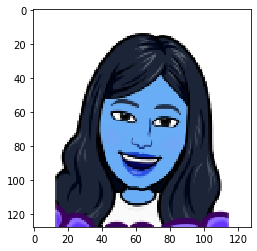

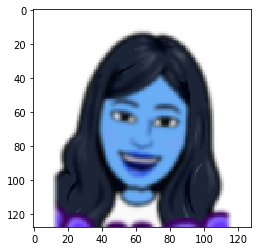

In [33]:
img = cv2.imread(bitmojis[4])
img = cv2.resize(img, (128, 128))
plt.imshow(img)
plt.show()
plt.imshow(do_smoothing(img))
plt.show()

# Training GAN

In [34]:
len(faces), len(bitmojis)

(35000, 4084)

Human Face Images


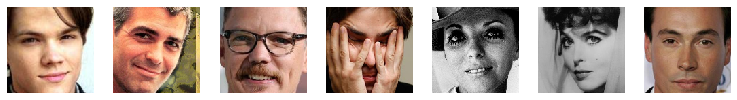

Bitmojis Version


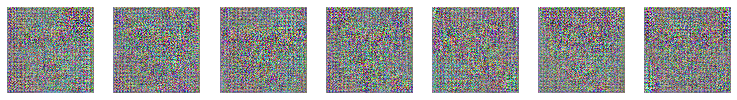

INFO:tensorflow:Assets written to: /Users/k15/Downloads/BitmojiDataset/weights/mod_0_0/assets
Epoch:0, Step:0, D-Loss:9.202, D-Acc:46.745, G-Loss:19.397
Epoch:0, Step:100, D-Loss:0.253, D-Acc:64.453, G-Loss:7.956
Human Face Images


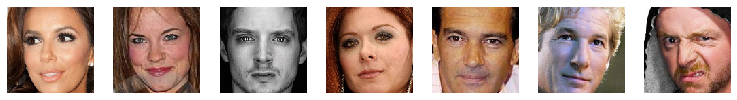

Bitmojis Version


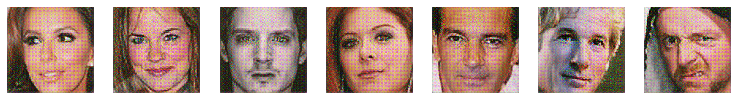

INFO:tensorflow:Assets written to: /Users/k15/Downloads/BitmojiDataset/weights/mod_0_200/assets
Epoch:0, Step:200, D-Loss:0.166, D-Acc:76.953, G-Loss:5.981
Epoch:0, Step:300, D-Loss:0.067, D-Acc:95.703, G-Loss:4.771
Human Face Images


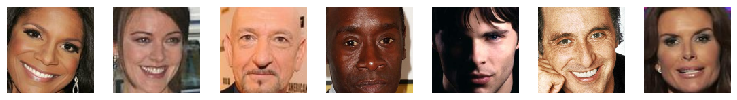

Bitmojis Version


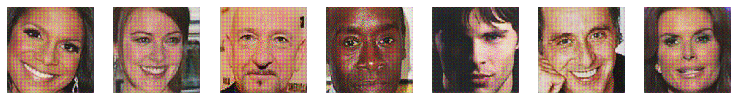

INFO:tensorflow:Assets written to: /Users/k15/Downloads/BitmojiDataset/weights/mod_0_400/assets
Epoch:0, Step:400, D-Loss:0.069, D-Acc:95.833, G-Loss:3.998
Epoch:0, Step:500, D-Loss:0.050, D-Acc:97.135, G-Loss:3.512
Human Face Images


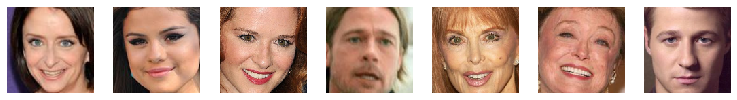

Bitmojis Version


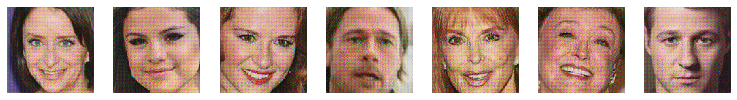

INFO:tensorflow:Assets written to: /Users/k15/Downloads/BitmojiDataset/weights/mod_0_600/assets
Epoch:0, Step:600, D-Loss:0.058, D-Acc:96.094, G-Loss:3.408
Epoch:0, Step:700, D-Loss:0.042, D-Acc:98.307, G-Loss:2.708
Human Face Images


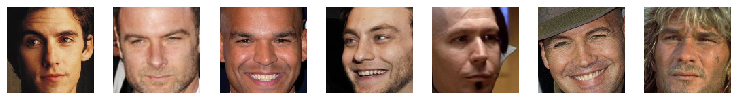

Bitmojis Version


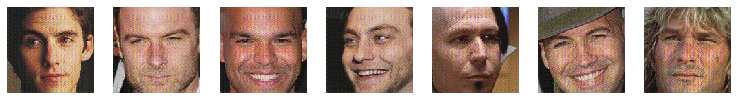

INFO:tensorflow:Assets written to: /Users/k15/Downloads/BitmojiDataset/weights/mod_0_800/assets
Epoch:0, Step:800, D-Loss:0.042, D-Acc:99.349, G-Loss:2.681
Epoch:0, Step:900, D-Loss:0.009, D-Acc:100.000, G-Loss:2.804
Human Face Images


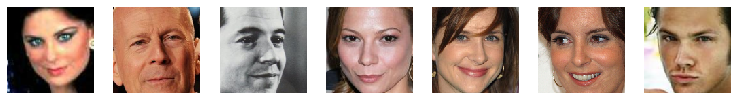

Bitmojis Version


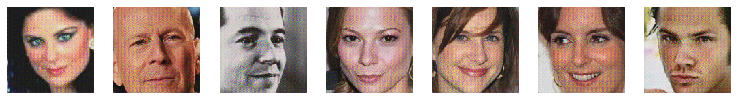

INFO:tensorflow:Assets written to: /Users/k15/Downloads/BitmojiDataset/weights/mod_1_0/assets
Epoch:1, Step:0, D-Loss:0.088, D-Acc:94.010, G-Loss:2.657
Epoch:1, Step:100, D-Loss:0.079, D-Acc:96.615, G-Loss:3.140


In [ ]:
epochs = 500
batch_size = 4
steps = 1000

for i in range(0, epochs):
    for j in range(steps): 
        if j%200 == 0:
            show_generator_results(generator_network)
            generator_network.save("/Users/k15/Downloads/BitmojiDataset/weights/mod_" + str(i) + "_" + str(j))

        human_faces, cartoon_faces, smooth_cartoon_faces = get_training_samples(batch_size)

        fake_patch = np.zeros((batch_size, 8, 8, 1))
        real_patch = np.ones((batch_size, 8, 8, 1))
        
        fake_cartoon_faces = generator_network(human_faces)
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d_real = discriminator_network.train_on_batch(cartoon_faces, real_patch)
        loss_d_smooth = discriminator_network.train_on_batch(smooth_cartoon_faces, fake_patch)
        loss_d_fake = discriminator_network.train_on_batch(fake_cartoon_faces, fake_patch)
        
        loss_d = np.add(loss_d_real, np.add(loss_d_smooth, loss_d_fake))/3.0
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        discriminator_network.trainable=False

        # Updating Generator weights
        loss_g = cartoon_gan.train_on_batch(human_faces,[real_patch, human_faces])
        
        if j%100 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g[0]))
            

Human Face Images


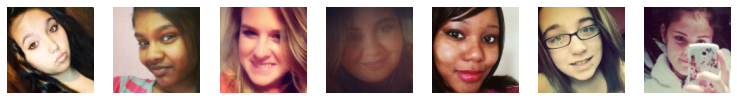

Anime Version


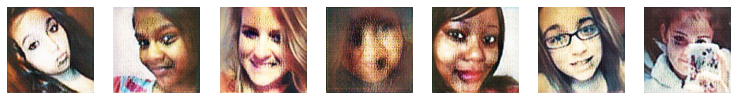

Human Face Images


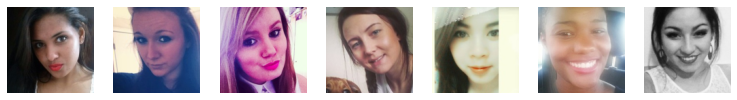

Anime Version


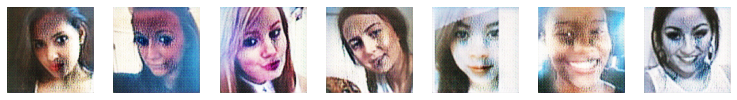

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/GAN_datasets/face_to_cartoon_new_0_0/assets
Epoch:0, Step:0, D-Loss:0.167, D-Acc:76.172, G-Loss:6.613
Epoch:0, Step:100, D-Loss:0.160, D-Acc:76.302, G-Loss:6.652
Human Face Images


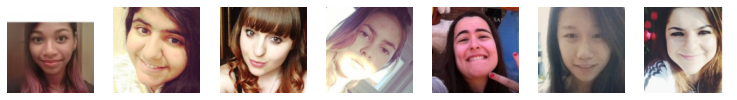

Anime Version


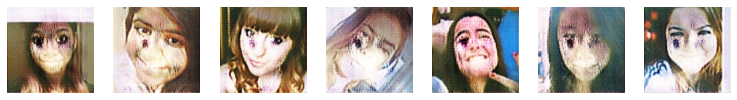

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/GAN_datasets/face_to_cartoon_new_0_200/assets
Epoch:0, Step:200, D-Loss:0.150, D-Acc:77.995, G-Loss:7.435
Epoch:0, Step:300, D-Loss:0.166, D-Acc:80.078, G-Loss:10.125
Human Face Images


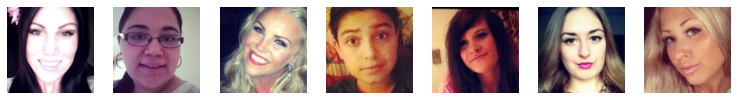

Anime Version


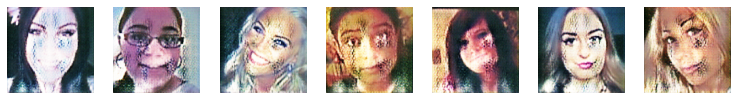

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/GAN_datasets/face_to_cartoon_new_0_400/assets
Epoch:0, Step:400, D-Loss:0.173, D-Acc:73.438, G-Loss:9.121
Epoch:0, Step:500, D-Loss:0.127, D-Acc:83.594, G-Loss:8.269
Human Face Images


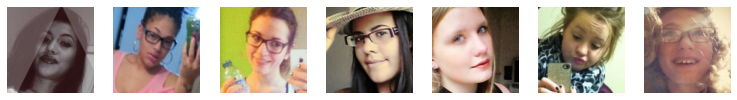

Anime Version


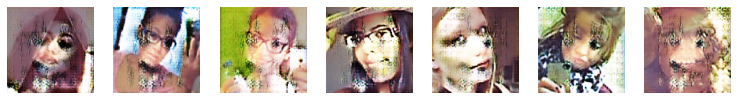

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/GAN_datasets/face_to_cartoon_new_0_600/assets
Epoch:0, Step:600, D-Loss:0.122, D-Acc:85.417, G-Loss:9.800
Epoch:0, Step:700, D-Loss:0.186, D-Acc:74.870, G-Loss:10.273
Human Face Images


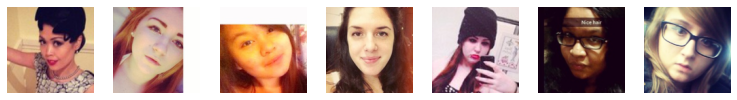

Anime Version


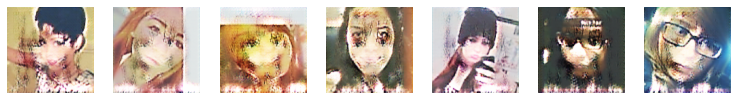

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/GAN_datasets/face_to_cartoon_new_0_800/assets
Epoch:0, Step:800, D-Loss:0.162, D-Acc:77.995, G-Loss:10.563
Epoch:0, Step:900, D-Loss:0.151, D-Acc:77.734, G-Loss:10.031
Human Face Images


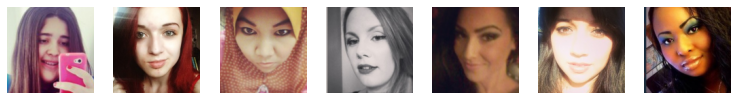

Anime Version


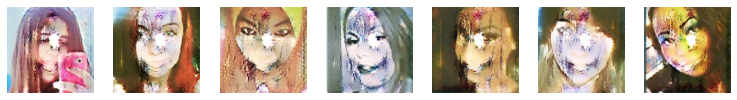

Human Face Images


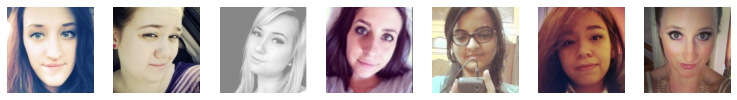

Anime Version


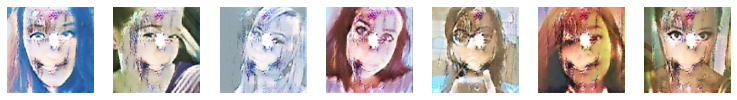

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/GAN_datasets/face_to_cartoon_new_1_0/assets
Epoch:1, Step:0, D-Loss:0.159, D-Acc:75.521, G-Loss:9.447
Epoch:1, Step:100, D-Loss:0.126, D-Acc:85.547, G-Loss:10.445
Human Face Images


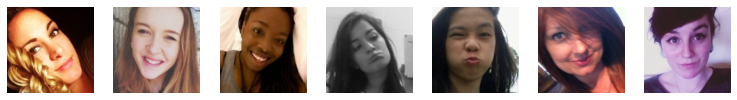

Anime Version


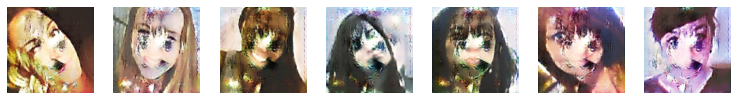

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/GAN_datasets/face_to_cartoon_new_1_200/assets
Epoch:1, Step:200, D-Loss:0.147, D-Acc:78.516, G-Loss:9.483
Epoch:1, Step:300, D-Loss:0.127, D-Acc:85.547, G-Loss:10.318
Human Face Images


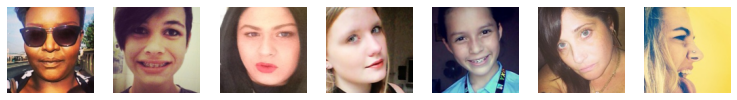

Anime Version


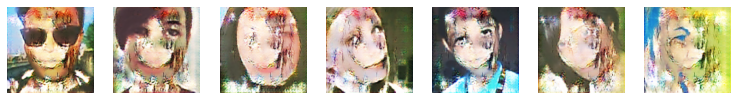

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/GAN_datasets/face_to_cartoon_new_1_400/assets
Epoch:1, Step:400, D-Loss:0.074, D-Acc:94.010, G-Loss:10.738
Epoch:1, Step:500, D-Loss:0.080, D-Acc:93.359, G-Loss:10.978
Human Face Images


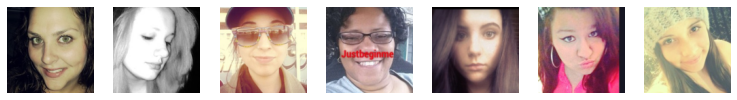

Anime Version


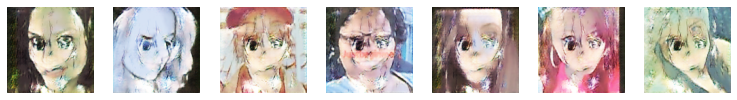

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/GAN_datasets/face_to_cartoon_new_1_600/assets
Epoch:1, Step:600, D-Loss:0.089, D-Acc:90.755, G-Loss:11.479
Epoch:1, Step:700, D-Loss:0.110, D-Acc:84.505, G-Loss:12.028


KeyboardInterrupt: ignored

In [30]:
epochs = 500
batch_size = 4
steps = 1000

for i in range(0, epochs):
    if i%1 == 0:
        show_generator_results(generator_network)
    for j in range(steps): 
        if j%200 == 0:
            show_generator_results(generator_network) 
            generator_network.save('/content/gdrive/MyDrive/GAN_datasets/face_to_cartoon_' + str(i) + "_" + str(j))

        human_faces, cartoon_faces, smooth_cartoon_faces = get_training_samples(batch_size)

        fake_patch = np.zeros((batch_size, 8, 8, 1))
        real_patch = np.ones((batch_size, 8, 8, 1))
        
        fake_cartoon_faces = generator_network(human_faces)
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d_real = discriminator_network.train_on_batch(cartoon_faces, real_patch)
        loss_d_smooth = discriminator_network.train_on_batch(smooth_cartoon_faces, fake_patch)
        loss_d_fake = discriminator_network.train_on_batch(fake_cartoon_faces, fake_patch)
        
        loss_d = np.add(loss_d_real, np.add(loss_d_smooth, loss_d_fake))/3.0
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        discriminator_network.trainable=False

        # Updating Generator weights
        loss_g = cartoon_gan.train_on_batch(human_faces,[real_patch, human_faces])
        
        if j%100 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g[0]))

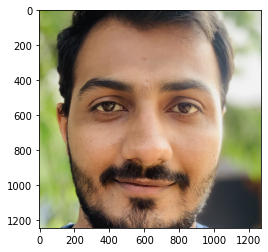

In [ ]:
import tensorflow
import cv2
import matplotlib.pyplot as plt
model = tensorflow.keras.models.load_model('/content/gdrive/MyDrive/GAN_datasets/face_to_anime_0_600')
img = cv2.imread('/content/gdrive/MyDrive/GAN_datasets/kartik1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

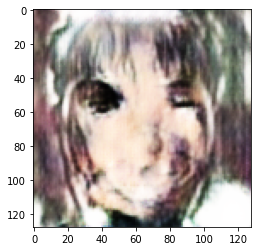

In [ ]:
img2 = cv2.resize(img, (128, 128))
img2 = ((img2-127.5)/127.5)
anime = model.predict_on_batch(np.array([img2]))[0]
anime = (anime + 1.0)/2.0
plt.imshow(anime)
plt.show()